In [1]:
!pip install torch torchvision matplotlib --quiet


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os, random


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE, "| GPU:" , torch.cuda.get_device_name(0) if DEVICE=="cuda" else "CPU")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Device: cuda | GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
def get_loaders(batch_size=64):
    # MNIST (1×32×32)
    tf_mnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2, fill=0),   # 28→32
    ])
    mnist = datasets.MNIST(root="data", train=True, download=True, transform=tf_mnist)
    mnist_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

    # CIFAR-10 (3×32×32)
    tf_cifar = transforms.Compose([
        transforms.ToTensor()
    ])
    cifar = datasets.CIFAR10(root="data", train=True, download=True, transform=tf_cifar)
    cifar_loader = DataLoader(cifar, batch_size=batch_size, shuffle=True)

    return mnist_loader, cifar_loader

mnist_loader, cifar_loader = get_loaders()
print("Loaded MNIST and CIFAR-10.")


Files already downloaded and verified
Loaded MNIST and CIFAR-10.


In [5]:
def three_disjoint_masks_like(img):
    """
    Create 3 disjoint binary masks with shape like img (B,C,H,W or C,H,W).
    At every pixel exactly one mask is 1 (others 0). Sum of masks == 1.
    """
    if img.dim() == 4:
        B,C,H,W = img.shape
        choice = torch.randint(0, 3, (B, 1, H, W), device=img.device)  # 0/1/2 per pixel
        m1 = (choice == 0).float()
        m2 = (choice == 1).float()
        m3 = (choice == 2).float()
        return m1, m2, m3
    else:
        C,H,W = img.shape
        choice = torch.randint(0, 3, (1, H, W), device=img.device)
        m1 = (choice == 0).float()
        m2 = (choice == 1).float()
        m3 = (choice == 2).float()
        return m1, m2, m3

def make_three_shares_exact(img):
    """
    Build three shares using disjoint masks (exact reconstruction via sum).
    img expected in [0,1] (float), shape (C,H,W) or (B,C,H,W).
    """
    m1, m2, m3 = three_disjoint_masks_like(img)
    s1 = img * m1
    s2 = img * m2
    s3 = img * m3
    return (s1, s2, s3), (m1, m2, m3)

def reconstruct_exact(s1, s2, s3):
    return torch.clamp(s1 + s2 + s3, 0.0, 1.0)


In [6]:
def float_to_uint8(x):
    x = torch.clamp(x, 0, 1)
    return (x * 255.0 + 0.5).to(torch.uint8)

def uint8_to_float(x):
    return x.to(torch.float32) / 255.0

def make_three_shares_xor(img):
    """
    Byte-wise XOR 3-share splitting. img float in [0,1], shape (C,H,W) or (B,C,H,W).
    Returns three uint8 shares.
    """
    x = float_to_uint8(img)
    r1 = torch.randint(0, 256, x.shape, dtype=torch.uint8, device=x.device)
    r2 = torch.randint(0, 256, x.shape, dtype=torch.uint8, device=x.device)
    s3 = x ^ r1 ^ r2
    return r1, r2, s3

def reconstruct_xor(s1, s2, s3):
    x = s1 ^ s2 ^ s3
    return uint8_to_float(x)


In [7]:
def show_row(imgs, titles, is_gray):
    n = len(imgs)
    plt.figure(figsize=(3.0*n, 3.2))
    for i, im in enumerate(imgs, 1):
        plt.subplot(1, n, i)
        im = im.detach().cpu()
        if im.dim() == 4:     # (B,C,H,W) -> pick first
            im = im[0]
        if im.shape[0] == 1 or is_gray:
            plt.imshow(im.squeeze(0), cmap="gray", vmin=0, vmax=1)
        else:
            plt.imshow(np.transpose(im.numpy(), (1,2,0)))
        plt.axis("off")
        plt.title(titles[i-1])
    plt.tight_layout()
    plt.show()

os.makedirs("three_share_samples", exist_ok=True)


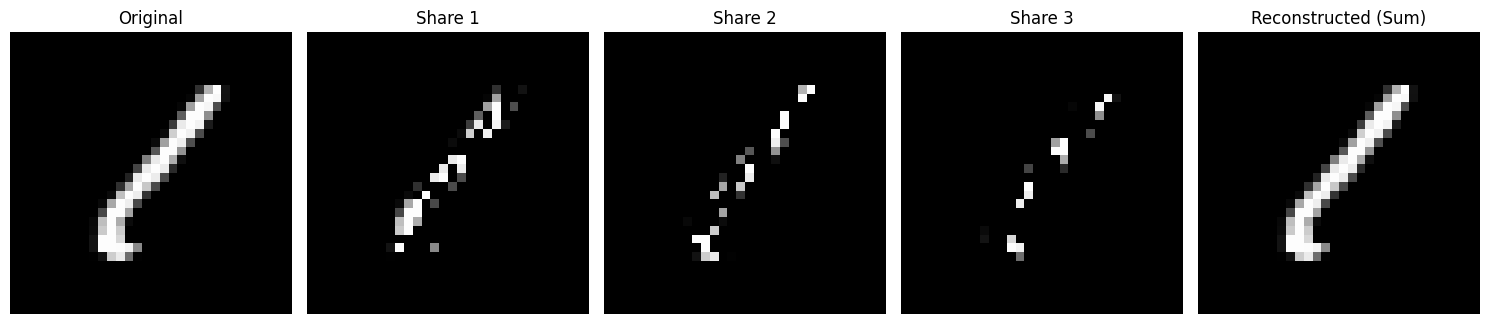

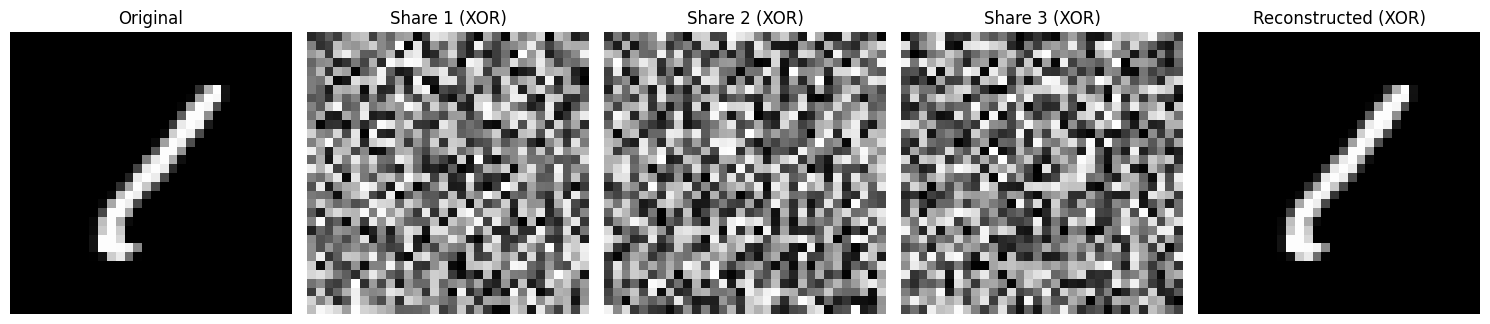

Saved MNIST samples to three_share_samples/


In [8]:
# Grab a mini-batch
mnist_imgs, _ = next(iter(mnist_loader))
mnist_imgs = mnist_imgs.to(DEVICE)  # (B,1,32,32)
is_gray = True

# ----- Exact (partition masks) -----
(sh1, sh2, sh3), (m1, m2, m3) = make_three_shares_exact(mnist_imgs)
recon_exact_mnist = reconstruct_exact(sh1, sh2, sh3)

show_row(
    [mnist_imgs, sh1, sh2, sh3, recon_exact_mnist],
    ["Original", "Share 1", "Share 2", "Share 3", "Reconstructed (Sum)"],
    is_gray=True
)

# Save a grid example
plt.imsave("three_share_samples/mnist_original.png", mnist_imgs[0,0].detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
plt.imsave("three_share_samples/mnist_recon_exact.png", recon_exact_mnist[0,0].detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)

# ----- XOR variant (byte-wise) -----
s1_u8, s2_u8, s3_u8 = make_three_shares_xor(mnist_imgs)
recon_xor_mnist = reconstruct_xor(s1_u8, s2_u8, s3_u8)

show_row(
    [mnist_imgs, uint8_to_float(s1_u8), uint8_to_float(s2_u8), uint8_to_float(s3_u8), recon_xor_mnist],
    ["Original", "Share 1 (XOR)", "Share 2 (XOR)", "Share 3 (XOR)", "Reconstructed (XOR)"],
    is_gray=True
)

plt.imsave("three_share_samples/mnist_recon_xor.png", recon_xor_mnist[0,0].detach().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
print("Saved MNIST samples to three_share_samples/")


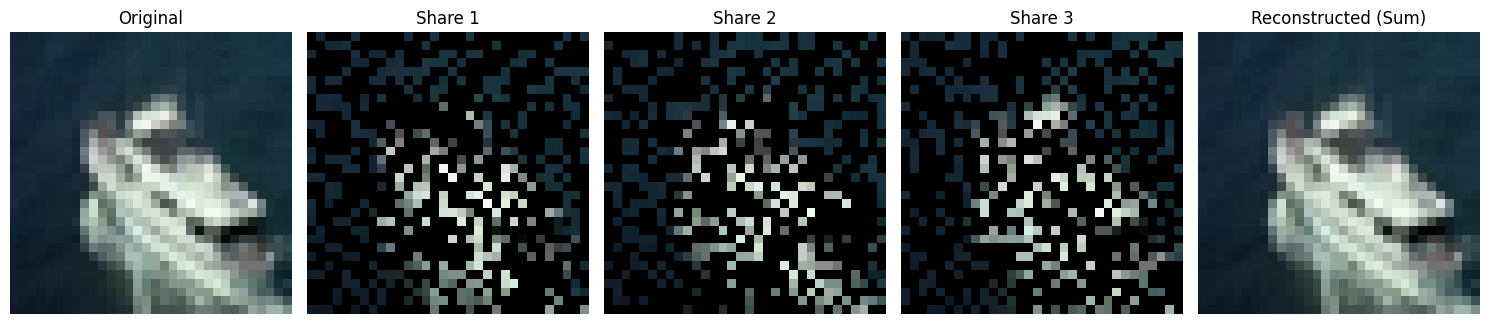

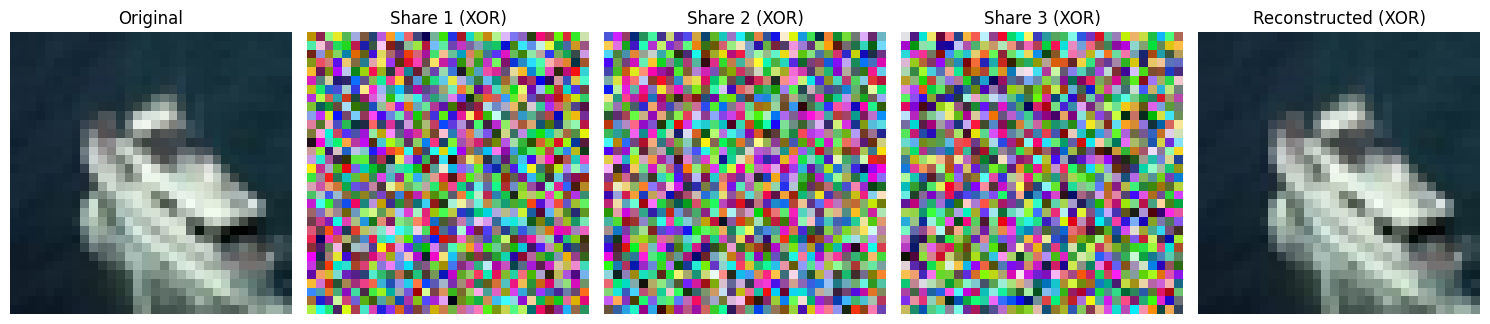

Saved CIFAR samples to three_share_samples/


In [9]:
cifar_imgs, _ = next(iter(cifar_loader))
cifar_imgs = cifar_imgs.to(DEVICE)  # (B,3,32,32)
is_gray = False

# ----- Exact (partition masks) -----
(sh1c, sh2c, sh3c), _ = make_three_shares_exact(cifar_imgs)
recon_exact_cifar = reconstruct_exact(sh1c, sh2c, sh3c)

show_row(
    [cifar_imgs, sh1c, sh2c, sh3c, recon_exact_cifar],
    ["Original", "Share 1", "Share 2", "Share 3", "Reconstructed (Sum)"],
    is_gray=False
)

# Save a sample
plt.imsave("three_share_samples/cifar_original.png", np.transpose(cifar_imgs[0].detach().cpu().numpy(), (1,2,0)))
plt.imsave("three_share_samples/cifar_recon_exact.png", np.transpose(recon_exact_cifar[0].detach().cpu().numpy(), (1,2,0)))

# ----- XOR variant (byte-wise) -----
s1_u8c, s2_u8c, s3_u8c = make_three_shares_xor(cifar_imgs)
recon_xor_cifar = reconstruct_xor(s1_u8c, s2_u8c, s3_u8c)

show_row(
    [cifar_imgs, uint8_to_float(s1_u8c), uint8_to_float(s2_u8c), uint8_to_float(s3_u8c), recon_xor_cifar],
    ["Original", "Share 1 (XOR)", "Share 2 (XOR)", "Share 3 (XOR)", "Reconstructed (XOR)"],
    is_gray=False
)

plt.imsave("three_share_samples/cifar_recon_xor.png", np.transpose(recon_xor_cifar[0].detach().cpu().numpy(), (1,2,0)))
print("Saved CIFAR samples to three_share_samples/")


In [10]:
import os
os.getcwd()


'C:\\Users\\TUF GAMING'